## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Inclusion Block(s)

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from os.path import basename

%matplotlib inline

##1a) Camera Calibration - Load Images

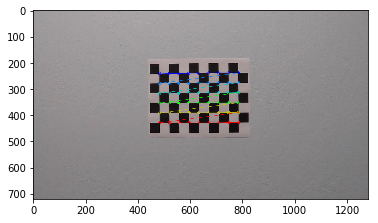

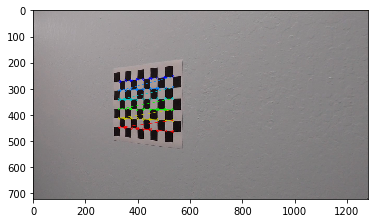

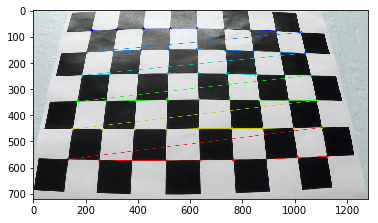

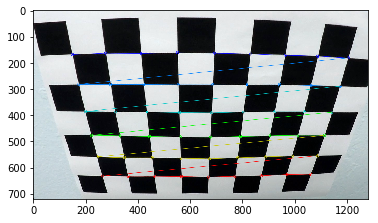

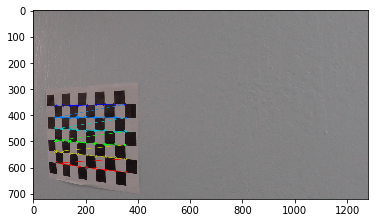

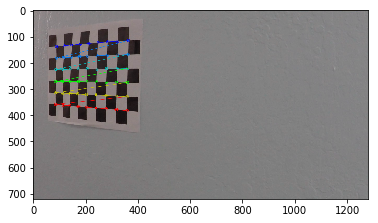

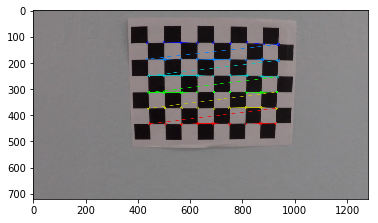

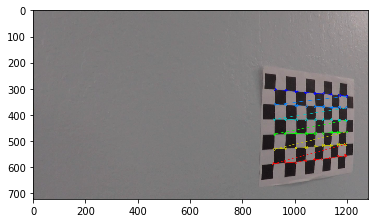

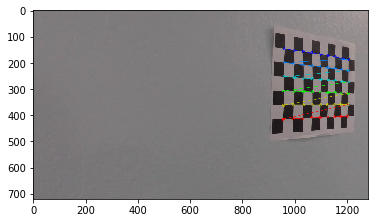

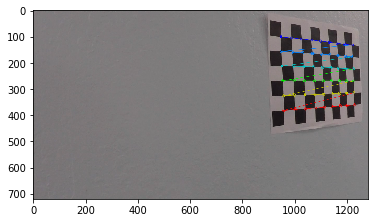

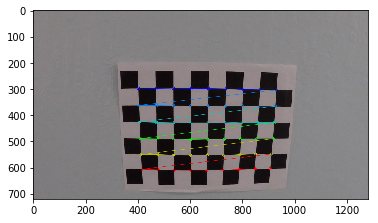

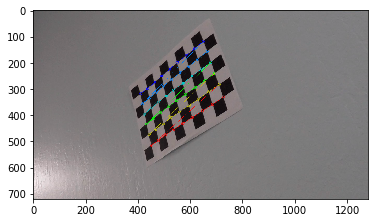

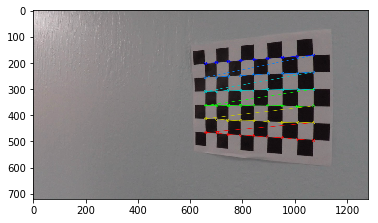

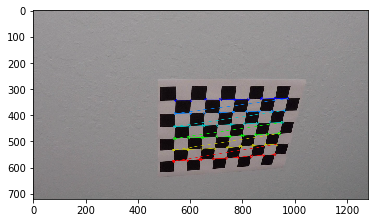

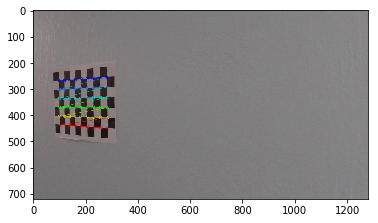

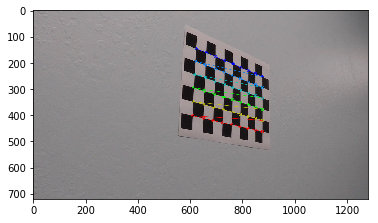

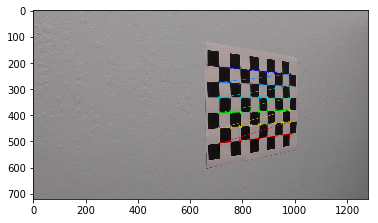

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    #print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        rootname = os.path.splitext(basename(fname))[0]
        #print(rootname)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imwrite('./output_images/chessboard/' + rootname +'_Chessboard.jpg', img)
        plt.figure()
        plt.imshow(img)


##1) Camera Calibration - Actual Calibration

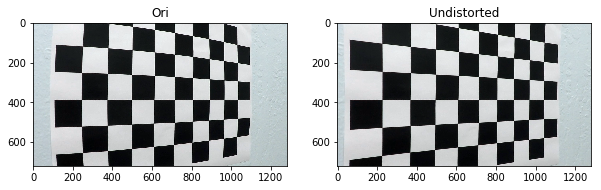

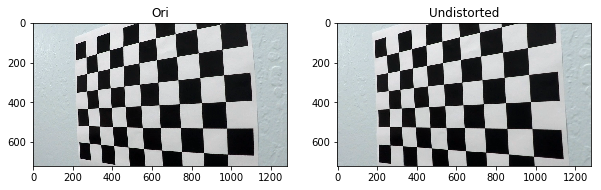

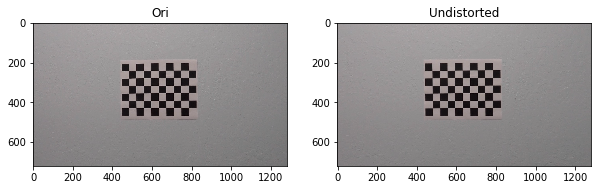

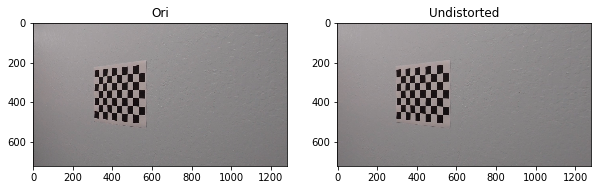

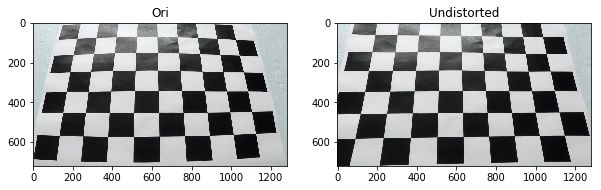

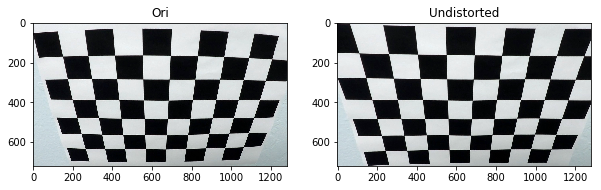

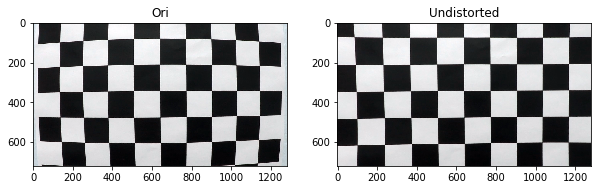

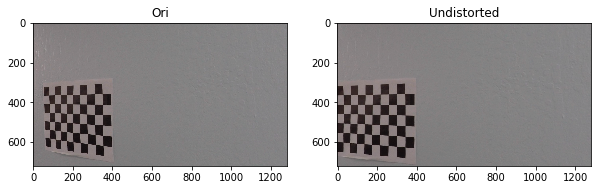

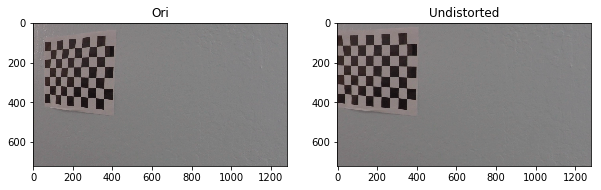

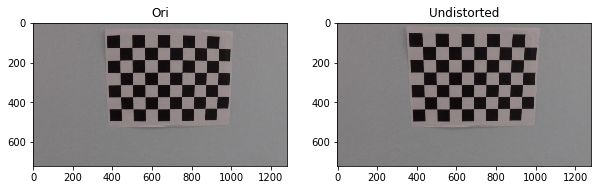

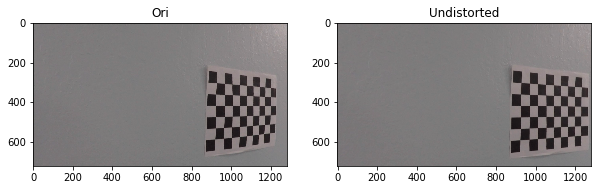

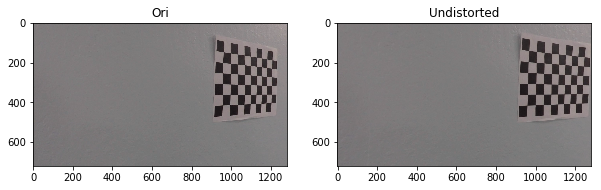

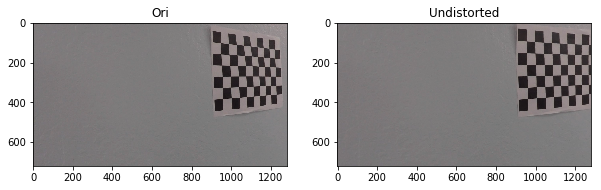

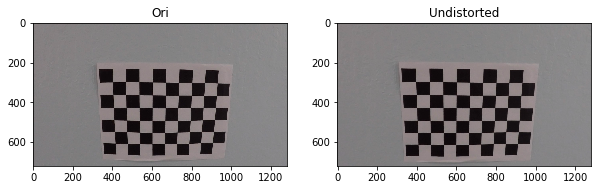

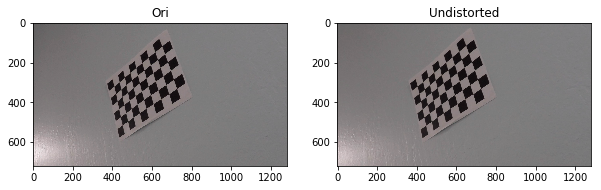

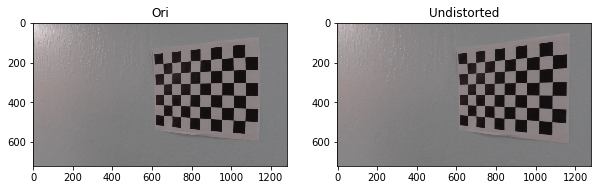

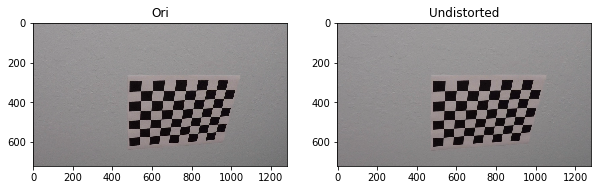

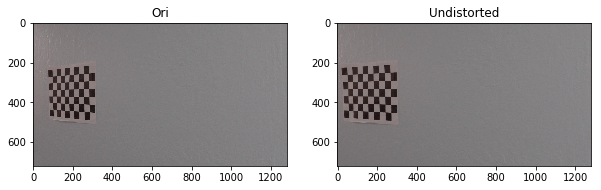

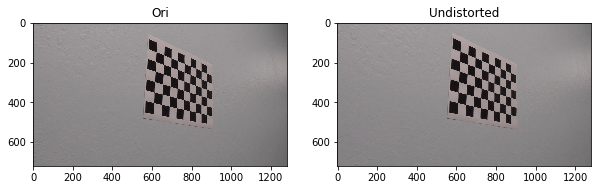

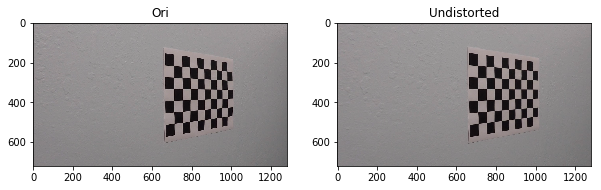

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,(img.shape[1],img.shape[0]),None, None)

for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    
    rootname = os.path.splitext(basename(fname))[0]
    cv2.imwrite('./output_images/undistorted/' + rootname +'_ChessboardUndistorted.jpg', dst)
    
    f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.imshow(img)
    ax1.set_title('Ori')
    ax2.imshow(dst)
    ax2.set_title('Undistorted')

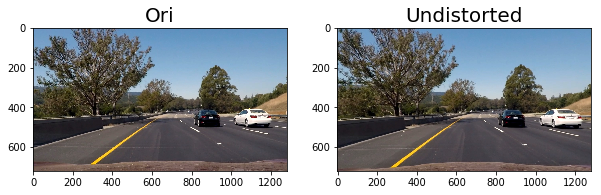

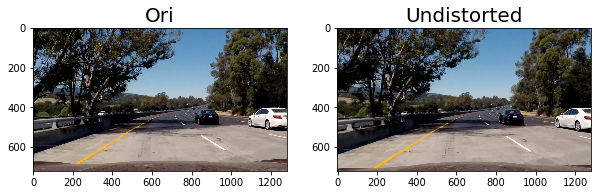

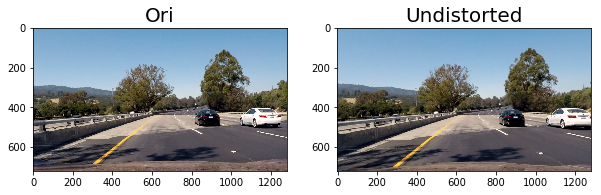

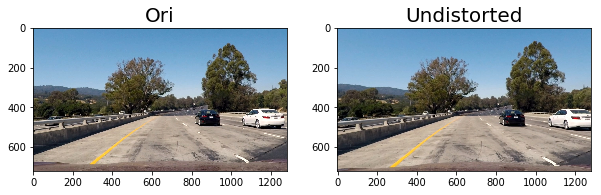

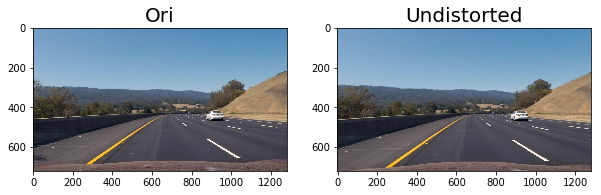

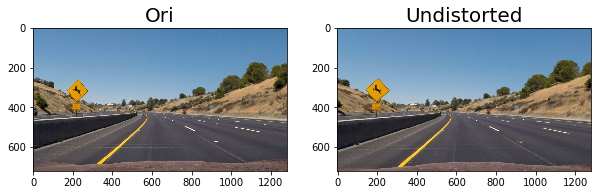

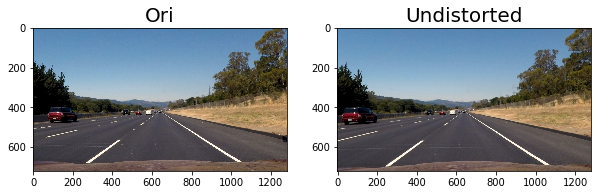

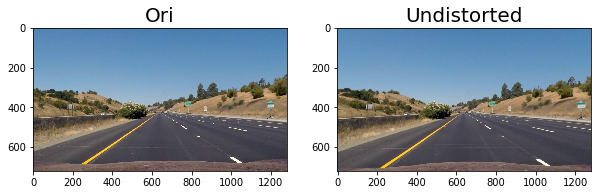

In [5]:
test_images = []
test_images_unsorted = []

images = glob.glob('test_images/*.jpg')
for fname in images:
    #print(fname)
    img = mpimg.imread(fname)
    test_images.append(img)
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    test_images_unsorted.append(dst)
    
    rootname = os.path.splitext(basename(fname))[0]
    cv2.imwrite('./output_images/undistorted/' + rootname +'_Undistorted.jpg', cv2.cvtColor(dst,cv2.COLOR_RGB2BGR))
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(img)
    ax1.set_title('Ori', fontsize=20)
    ax2.imshow(dst)
    ax2.set_title('Undistorted', fontsize=20)
    

Check Projection

In [6]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    plt.imshow(sx_binary,cmap='gray')
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sx_binary

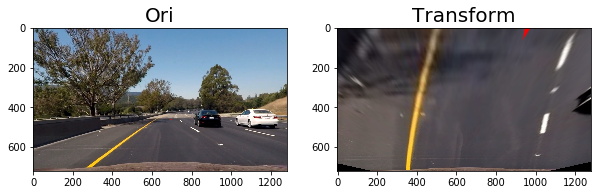

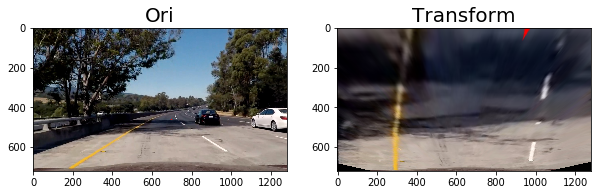

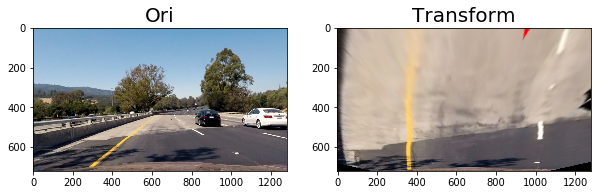

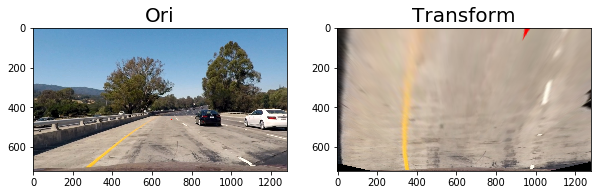

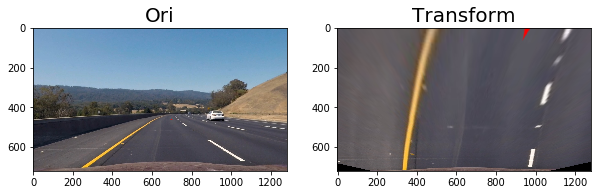

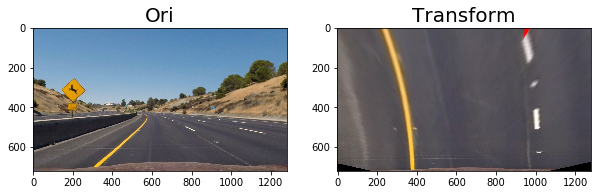

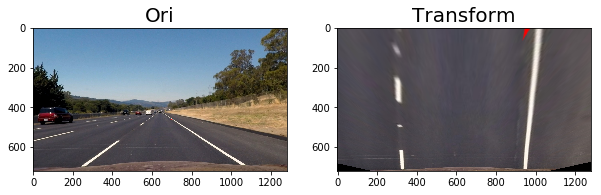

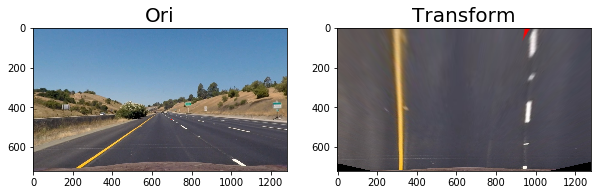

In [23]:
for cur_img in test_images_unsorted:
    
    #cur_img = abs_sobel_thresh(cur_img,orient='x',thresh_min=20, thresh_max=100)
    img_size = [cur_img.shape[1],cur_img.shape[0]]
    
    srcpts = np.array(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    dstpts = np.array(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(np.float32([srcpts]), np.float32([dstpts]))
    Minv = cv2.getPerspectiveTransform(np.float32([dstpts]), np.float32([srcpts]))
    
    
    dst = cv2.warpPerspective(cur_img, M, (img_size[0],img_size[1]), flags=cv2.INTER_LINEAR)
    dst = cv2.polylines(dst, np.int32([dstpts]), 2, (255,0,0), thickness=3)
    
    src = cv2.polylines(cur_img, np.int32([srcpts]), 2, (255,0,0), thickness=3)
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(cur_img)
    ax1.set_title('Ori', fontsize=20)
    ax2.imshow(dst)
    ax2.set_title('Transform', fontsize=20)


In [24]:
def conv2LSBinary(img, s_thresh = (170,255),sx_thresh=(20,100), sy_thresh=(20,100)):
    img_cur = np.copy(img)
    
    #img_hls=cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    #lum = img_hls[:,:,1]
    #sat = img_hls[:,:,2]
    
    gray = cv2.cvtColor(img_cur,cv2.COLOR_RGB2GRAY).astype(np.float)
    
    sx_binary = cv2.Sobel(gray,cv2.CV_64F,1,0)
    sx_binary = np.absolute(sx_binary)
    
    
    
    return sx_binary

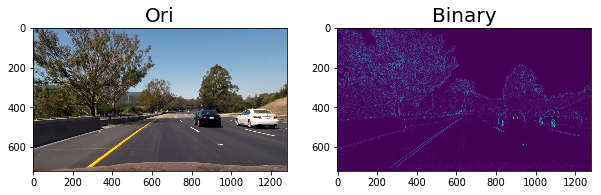

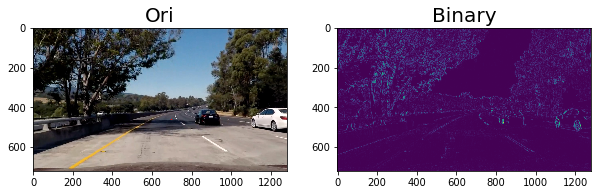

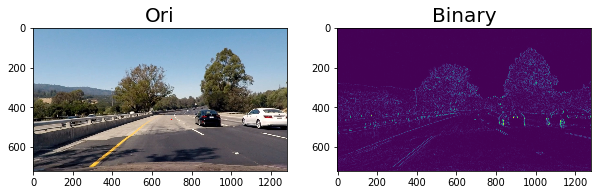

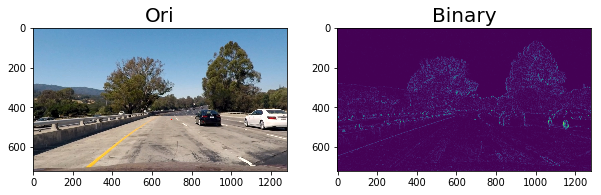

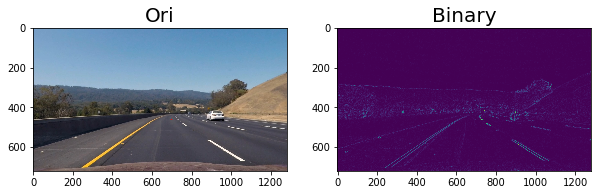

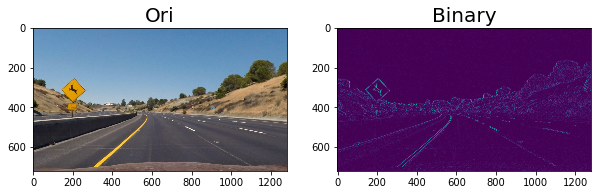

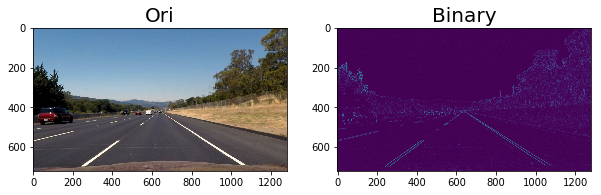

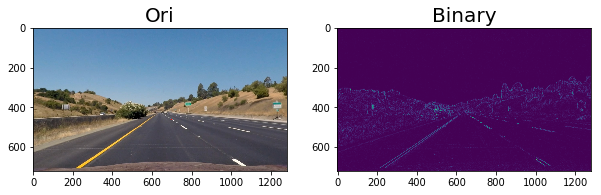

In [25]:
for cur_img in test_images_unsorted:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(cur_img)
    ax1.set_title('Ori', fontsize=20)
    ax2.imshow(conv2LSBinary(cur_img))
    ax2.set_title('Binary', fontsize=20)
    